In [1]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json
from scipy.optimize import minimize


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [2]:
start_day = '2020-03-02'
end_day   = '2020-07-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

We use Gerlee et al. to have a moving beta according to the data from the traffic. 

In [3]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


In [4]:
# storing the mobility in a csv file
store_mobility=False
if store_mobility:
    mobility_by_week=np.array([floatmobility[i//7] for i in range(len(all_days))])
    mobility_df=pd.DataFrame({'mobility': mobility_by_week})
    mobility_df.to_csv('mobility.csv')


In [5]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)

The values of beta seem very high compared to the previsous values found in litrerature. 


Creating parameters that fit the Swedish population

In [41]:
parameters_sweden=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )

parameters_sweden_bis=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  
                            location = 'Sweden',
                            pop_infected = 2, #value by default, TOCHANGE
                            
                            )



In [45]:
# interventions of changing beta: we create a cv.change_beta object that changes beta everyday according to the values of the traffic circulation. 
cb_mobility = cv.change_beta(days=all_days, changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 
cb_mobility_2= cv.change_beta(days=all_days, changes=betas_by_week, do_plot=False)

Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (12.44 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (15.89 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (19.42 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (23.03 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (26.90 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (31.27 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (35.09 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (39.00 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (43.25 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (48.44 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (54.18 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (61.53 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (69.52 s)  •••••••••••••••••••— 99%
Simulation summary:
      854,652 cumulative in

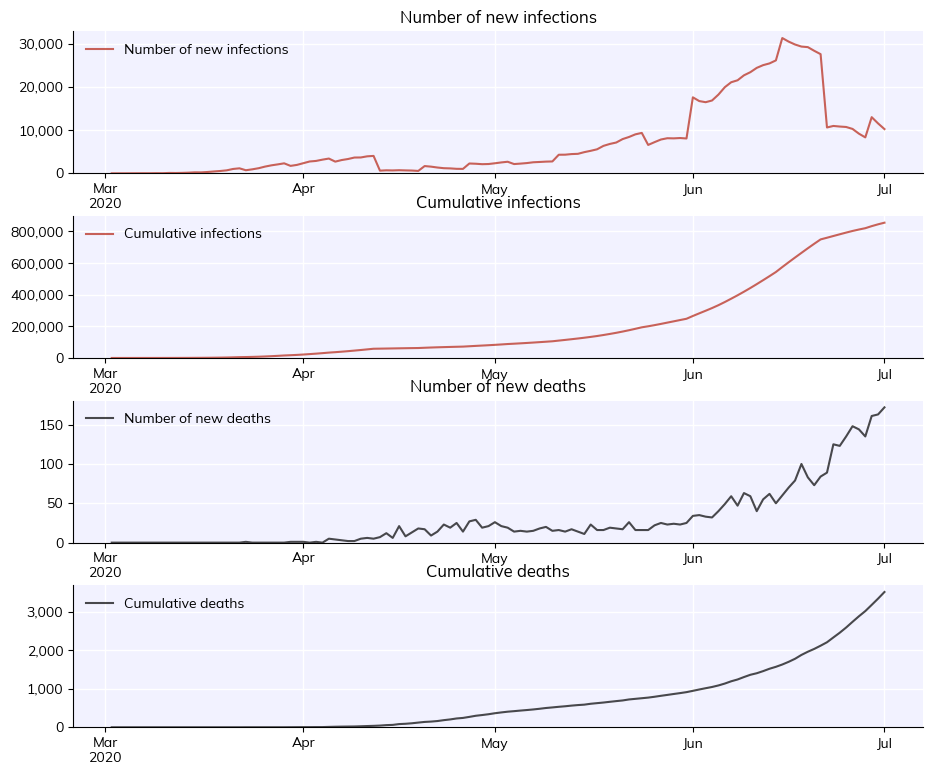

In [46]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions2=cv.Sim(parameters_sweden, interventions=cb_mobility_2)
    my_simulation_sweden_interventions2.run()
    my_simulation_sweden_interventions2.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])

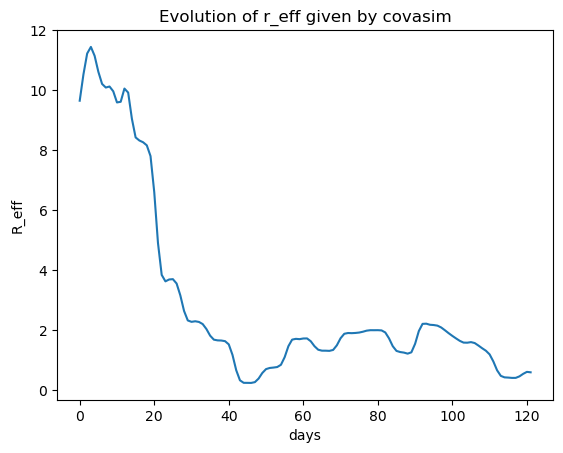

In [47]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions2.compute_r_eff())
plt.title('Evolution of r_eff given by covasim')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

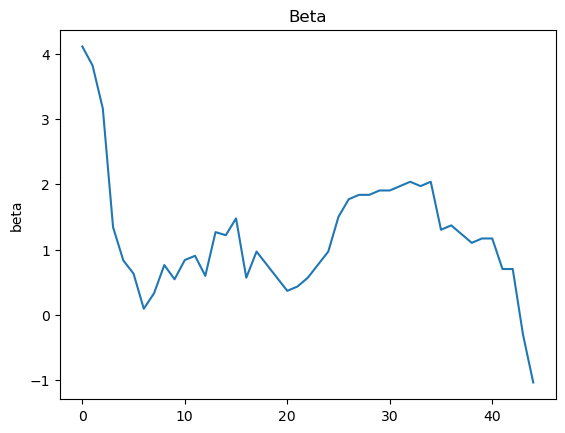

In [8]:
plt.plot(np.array(betas))
plt.title('Beta')
plt.ylabel('beta')
plt.show()


Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (11.67 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (14.75 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (18.08 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (21.43 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (24.91 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (28.21 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (31.61 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (35.26 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (39.68 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (45.22 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (52.64 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (60.77 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (68.62 s)  •••••••••••••••••••— 99%
Simulation summary:
      889,845 cumulative in

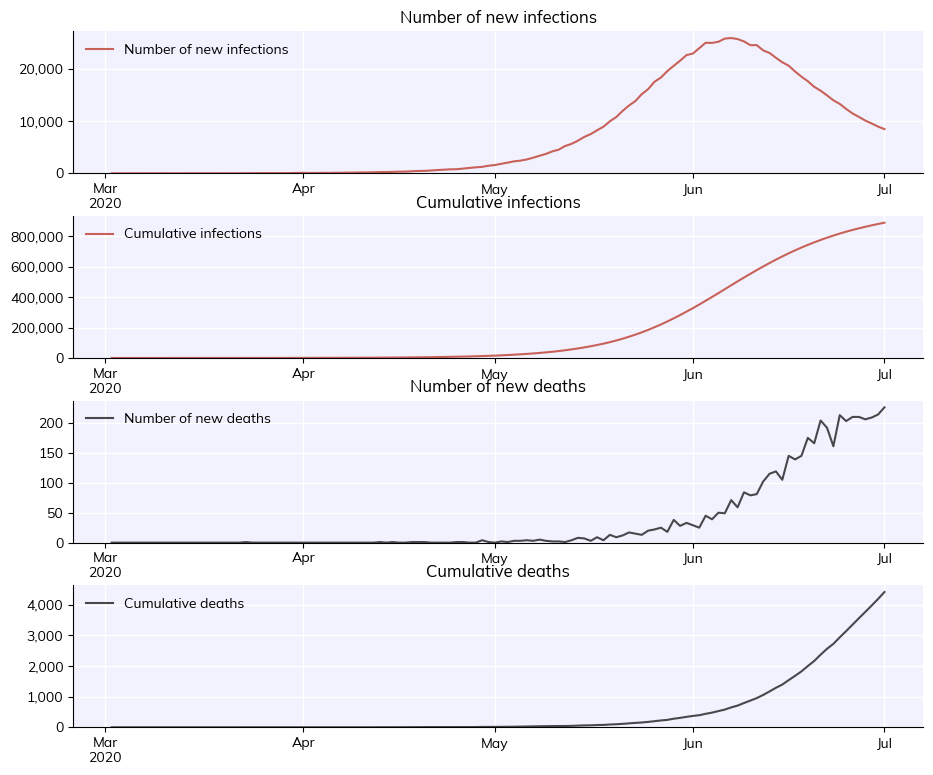

In [32]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions2=cv.Sim(parameters_sweden)
    my_simulation_sweden_interventions2.run()
    my_simulation_sweden_interventions2.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


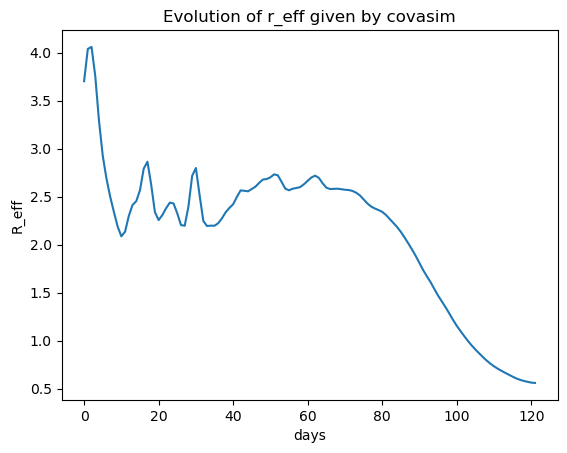

In [34]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions2.compute_r_eff())
plt.title('Evolution of r_eff given by covasim')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (13.13 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (16.41 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (24.72 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (36.09 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (47.62 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (58.46 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (68.31 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (80.69 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (91.95 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (103.07 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (117.21 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (137.12 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (152.09 s)  •••••••••••••••••••— 99%
Simulation summary:
    5,702,320 cumulativ

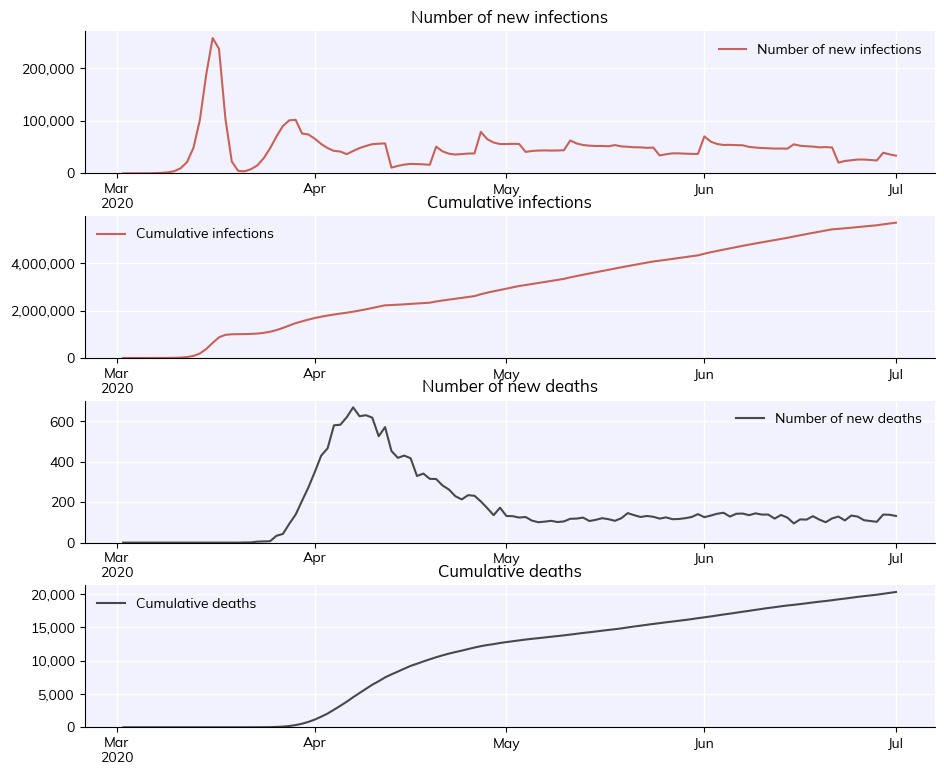

In [9]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
    my_simulation_sweden_interventions.run()
    my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


In [29]:
my_simulation_sweden_interventions.compute_r_eff()

array([1.15794520e+02, 1.26321295e+02, 1.33551753e+02, 1.36248741e+02,
       1.35636921e+02, 1.33533652e+02, 1.30496182e+02, 1.27313053e+02,
       1.24692759e+02, 1.22500651e+02, 1.19864187e+02, 1.14537455e+02,
       1.02860707e+02, 8.22581375e+01, 5.50669259e+01, 2.89614453e+01,
       1.12016985e+01, 2.95922381e+00, 5.16776878e-01, 1.09523779e-01,
       1.09855552e-01, 1.92546085e-01, 3.38036177e-01, 5.55994024e-01,
       8.40701458e-01, 1.15871206e+00, 1.42727052e+00, 1.54032891e+00,
       1.49130560e+00, 1.36653447e+00, 1.20091381e+00, 1.00107489e+00,
       8.17308885e-01, 6.87571628e-01, 6.10647106e-01, 5.88956774e-01,
       6.31264419e-01, 7.19371841e-01, 8.21263327e-01, 9.18729102e-01,
       9.45956021e-01, 7.87252314e-01, 5.06839119e-01, 3.38327409e-01,
       3.33329999e-01, 3.69474392e-01, 3.90669250e-01, 4.66184350e-01,
       7.16415346e-01, 1.06255003e+00, 1.26557178e+00, 1.30814513e+00,
       1.33599418e+00, 1.38327625e+00, 1.50154115e+00, 1.82309919e+00,
      

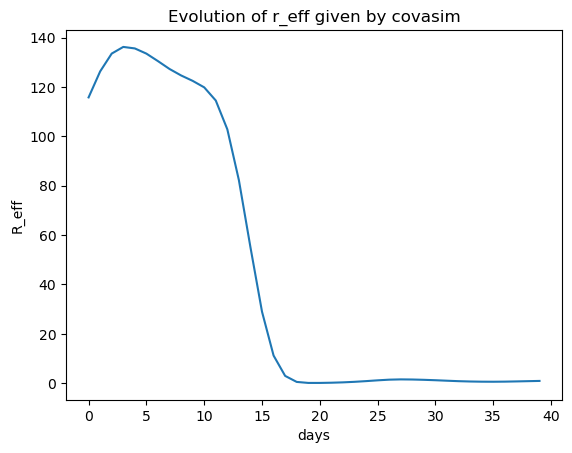

In [31]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions.compute_r_eff()[:40])
plt.title('Evolution of r_eff given by covasim')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

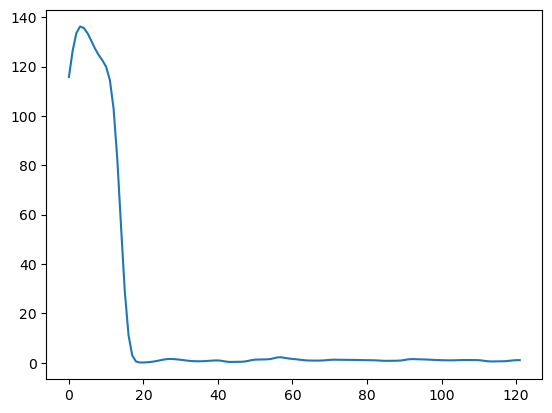

In [11]:
plt.plot(my_simulation_sweden_interventions.compute_r_eff())

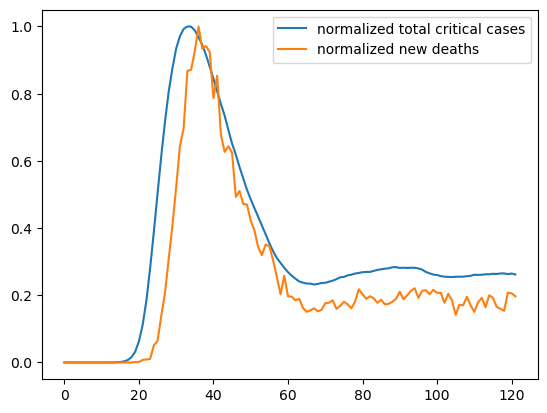

In [12]:
plt.plot(my_simulation_sweden_interventions.results['n_critical']/max(my_simulation_sweden_interventions.results['n_critical']), label='normalized total critical cases')
plt.plot(my_simulation_sweden_interventions.results['new_deaths']/max(my_simulation_sweden_interventions.results['new_deaths']), label='normalized new deaths')
plt.legend()
plt.show()


We have stored in a csv file the synthetized data and extract it as a baseline: 

In [13]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

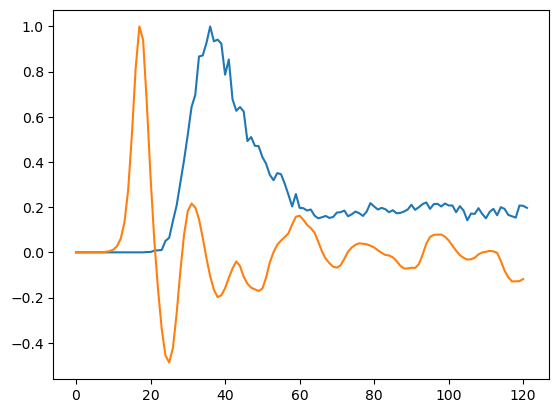

In [14]:
new_deaths=np.array(df['new_deaths'])
n_infected=np.array(df['n_infected'])
new_infected=np.array([n_infected[i+1] - n_infected[i] for i in range(len(n_infected) -1)])
plt.plot(new_deaths/max(new_deaths))
plt.plot(new_infected/max(new_infected))

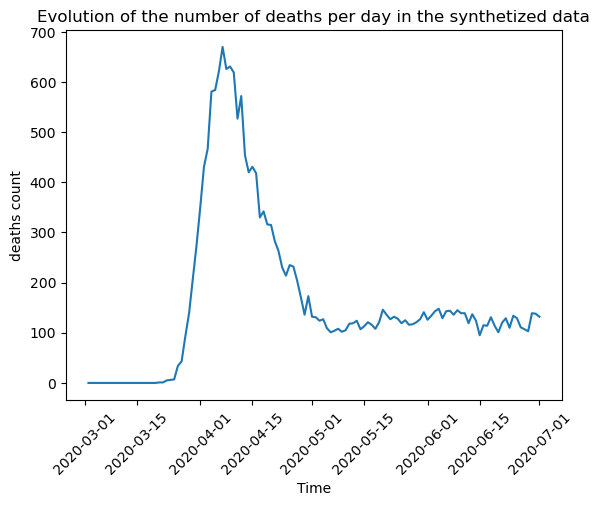

In [15]:
plt.plot(date_range, df['new_deaths'], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')

plt.show()

In [16]:
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

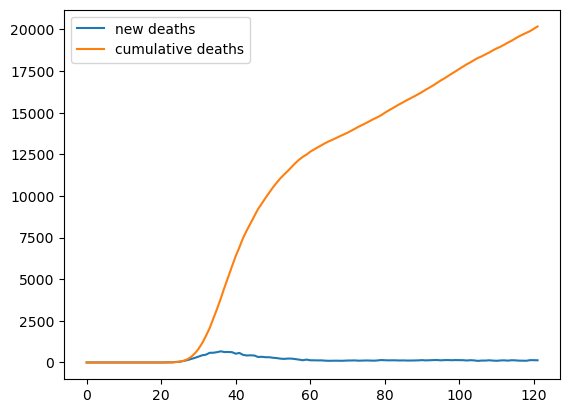

In [17]:
plt.plot(dates_of_pandemic,new_deaths, label='new deaths')
plt.plot(dates_of_pandemic,death_cumul, label='cumulative deaths')
plt.legend()
plt.show()

We try to fit some simple models

In [18]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [19]:
def polynomla_func(x, a, b, c, d, e , f):
    return a*x**2+b*x+c + e*x**3 

In [20]:
p, _ =curve_fit(exponential_func, dates_of_pandemic, new_deaths)
p
p2, _ =curve_fit(polynomla_func, dates_of_pandemic, new_deaths)


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


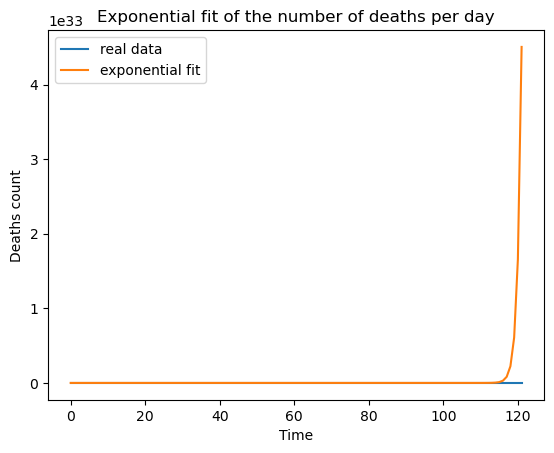

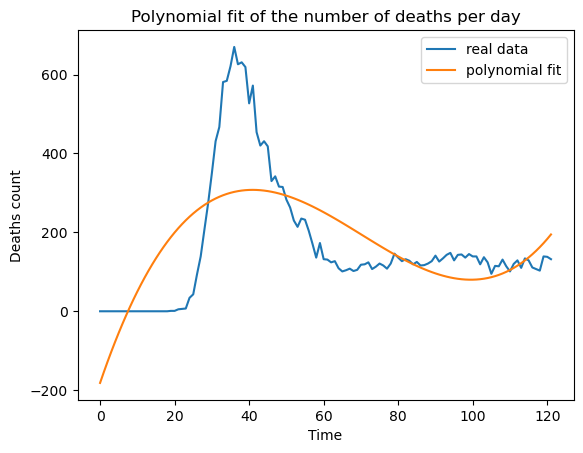

In [21]:
plt.plot(dates_of_pandemic,new_deaths, label='real data')
plt.plot(dates_of_pandemic, exponential_func(dates_of_pandemic, *p), label= 'exponential fit')
plt.title('Exponential fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()

plt.plot(dates_of_pandemic,new_deaths,  label='real data')
plt.plot(dates_of_pandemic, polynomla_func(dates_of_pandemic, *p2), label= 'polynomial fit')
plt.title('Polynomial fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()


